# Prescription-based caseness over time

The purpose of this notebook is to plot how the count of patient records meeting the prescription component of our caseness definition would change depending on the window that defines a "recent" prescription.

I will run a portion of the code used in `UNSEEN_create_caseness_variables.ipynb` to return the count of patients that have a prescription within 1-60 months of the index date.

### Imports

In [4]:
%run 'UNSEEN_helper_functions.ipynb'
%store -r

### Prerequisites

In [5]:
%%capture
# Set index date. Usually CURRENT_DATE() but Dec 2021 will be used until cB fixed the missing prescriptions.
myIndexDate =  '2021-12-31'

# Set the capture window that indicates an active prescription of the medications of interest.
meds_catch_window = range(60)

# Set parameters for disclosivity adjustments.
redaction_threshold = 7
target_round = 10

# Set the database attributes.
global server_id
server_id = 'yhcr-prd-phm-bia-core'
global database_id
database_id = 'CB_FDM_PrimaryCare_V7'

# Set folder location.
folder_loc = os.path.dirname(os.path.abspath("UNSEEN create caseness array.ipynb"))
folder = folder_loc + '/codelists/'

# Medications of interest.
medications_to_query_psychosisAndRelated = pandas.read_csv(folder + "UNSEEN_medications_psychosisAndRelated.csv")
medications_to_query_hypnoticsAndAnxiolytics = pandas.read_csv(folder + "UNSEEN_medications_hypnoticsAndAnxiolytics.csv")
medications_to_query_antidepressants = pandas.read_csv(folder + "UNSEEN_medications_antidepressants.csv")
medications_to_query_all = pandas.read_csv(folder + "UNSEEN_medications_list.csv")

# Set parameters for plotting.
%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})
matplotlib.pyplot.style.use('seaborn-whitegrid')
matplotlib.pyplot.xlabel('Months before the index date')
matplotlib.pyplot.xticks(
    numpy.concatenate(
        (
        numpy.arange(-60, 0, 12)
        ,numpy.arange(-6, 1, 2)
        )
    )
)

### Count patients with prescriptions between 0 and 60 months from index date.

In [6]:
pt_count = []
for i in tqdm(meds_catch_window, unit = 'window breath'):
    sql = """
    DECLARE myIndexDate DATE DEFAULT '""" + myIndexDate + """';

    WITH
    # The first CTE will specify the 'spine' of the data table by selecting the unique list of person IDs.
    tbl_persons AS (
        SELECT
            DISTINCT person_id
        FROM
            """ + server_id + """.""" + database_id + """.person
        # Limiting to age range 18-70.
        WHERE
            (EXTRACT(YEAR FROM CURRENT_DATE()) - year_of_birth) BETWEEN 18 AND 70
    )

    # The following CTEs extract each medication list into a SQL table before querying the person_ID 
    # associated with the medications (combined into medication type).
    #
    #  ## Drugs used in psychosis and related disorders.
    ,tbl_meds_psychosisAndRelated AS (
        SELECT
            my_nameofmedication
        FROM
            UNNEST([
                    '""" + '\', \''.join(map(str, medications_to_query_psychosisAndRelated["Medication"].tolist())) + """'
                    ]) AS my_nameofmedication
    )
    ,tbl_meds_psychosisAndRelated_persons AS (
        SELECT
          DISTINCT person_id
        FROM
          """ + server_id + """.""" + database_id + """.tbl_srprimarycaremedication, tbl_meds_psychosisAndRelated
        WHERE
            nameofmedication LIKE CAST(CONCAT('%',tbl_meds_psychosisAndRelated.my_nameofmedication,'%') AS STRING)
            AND DATE_DIFF(myIndexDate, CAST(datemedicationstart AS DATE), MONTH) = """ + str(i) + """
    )
    #  ## Hypnotics and anxiolyitcs
    ,tbl_meds_hypnoticsAndAnxiolytics AS (
        SELECT
            my_nameofmedication
        FROM
            UNNEST([
                    '""" + '\', \''.join(map(str, medications_to_query_hypnoticsAndAnxiolytics["Medication"].tolist())) + """'
                    ]) AS my_nameofmedication
    )
    ,tbl_meds_hypnoticsAndAnxiolytics_persons AS (
        SELECT
          DISTINCT person_id
        FROM
          """ + server_id + """.""" + database_id + """.tbl_srprimarycaremedication, tbl_meds_hypnoticsAndAnxiolytics
        WHERE
            nameofmedication LIKE CAST(CONCAT('%',tbl_meds_hypnoticsAndAnxiolytics.my_nameofmedication,'%') AS STRING)
            AND DATE_DIFF(myIndexDate, CAST(datemedicationstart AS DATE), MONTH) = """ + str(i) + """
    )
    #  ## Antidepressants
    ,tbl_meds_antidepressants AS (
        SELECT
            my_nameofmedication
        FROM
            UNNEST([
                    '""" + '\', \''.join(map(str, medications_to_query_antidepressants["Medication"].tolist())) + """'
                    ]) AS my_nameofmedication
    )
    ,tbl_meds_antidepressants_persons AS (
        SELECT
          DISTINCT person_id
        FROM
          """ + server_id + """.""" + database_id + """.tbl_srprimarycaremedication, tbl_meds_antidepressants
        WHERE
            nameofmedication LIKE CAST(CONCAT('%',tbl_meds_antidepressants.my_nameofmedication,'%') AS STRING)
            AND DATE_DIFF(myIndexDate, CAST(datemedicationstart AS DATE), MONTH) = """ + str(i) + """
    )   
    
    SELECT COUNT(*) FROM tbl_meds_antidepressants_persons
    """
    #print(f'i = {i}. The count of patients = {client.query(sql).to_dataframe().values[0].astype(int)[0]}')
    pt_count.append(pandas.read_gbq(sql).values[0].astype(int)[0])
pt_count_rounded = []
for i in pt_count:
    pt_count_rounded.append(round(i / target_round) * target_round)

  0%|          | 0/60 [00:00<?, ?window breath/s]/opt/conda/lib/python3.7/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
100%|██████████| 60/60 [01:27<00:00,  1.46s/window breath]


### Plot patients with prescriptions between 0 and 60 months from index date.

#### Increment by month

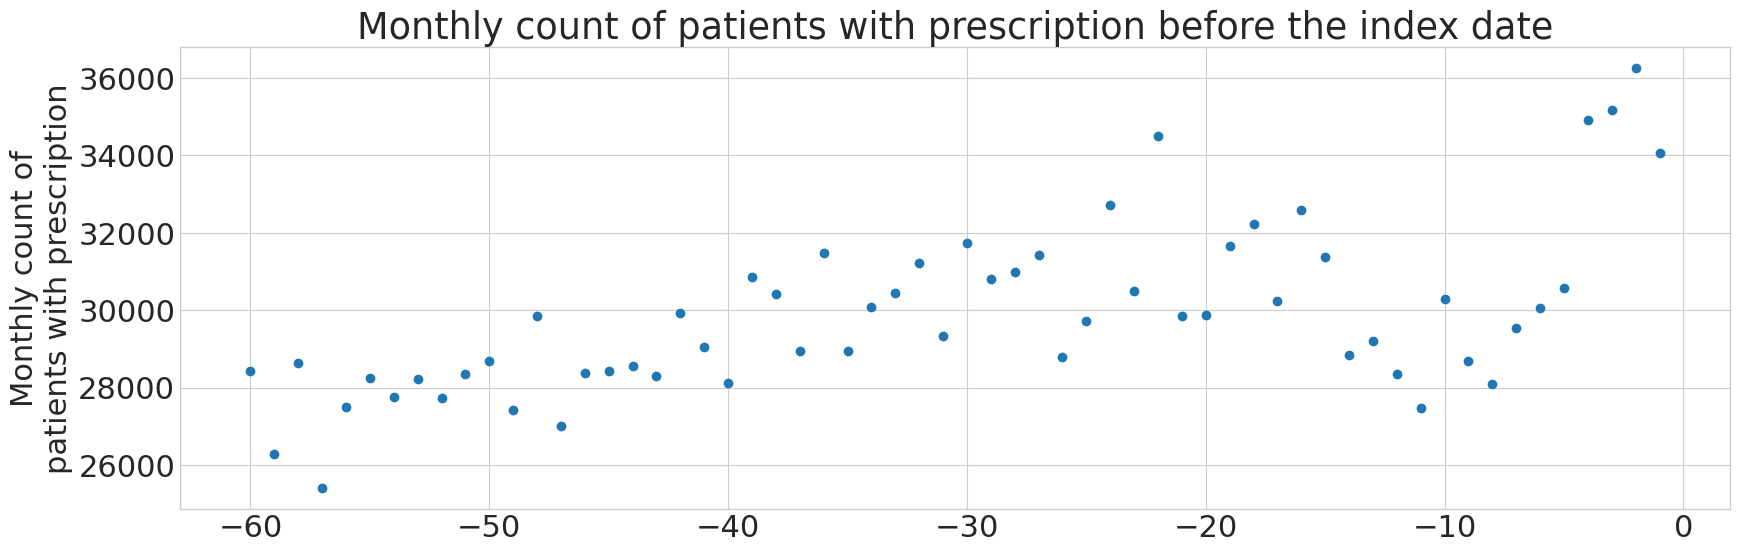

In [7]:
## Get the increments
pt_count_rounded.reverse()
# Plot.
fig = matplotlib.pyplot.figure(figsize=(20,6))
matplotlib.pyplot.title('Monthly count of patients with prescription before the index date')
matplotlib.pyplot.ylabel('Monthly count of\npatients with prescription')
matplotlib.pyplot.scatter(list(range(-len(pt_count_rounded),0)), pt_count_rounded)
matplotlib.pyplot.show()

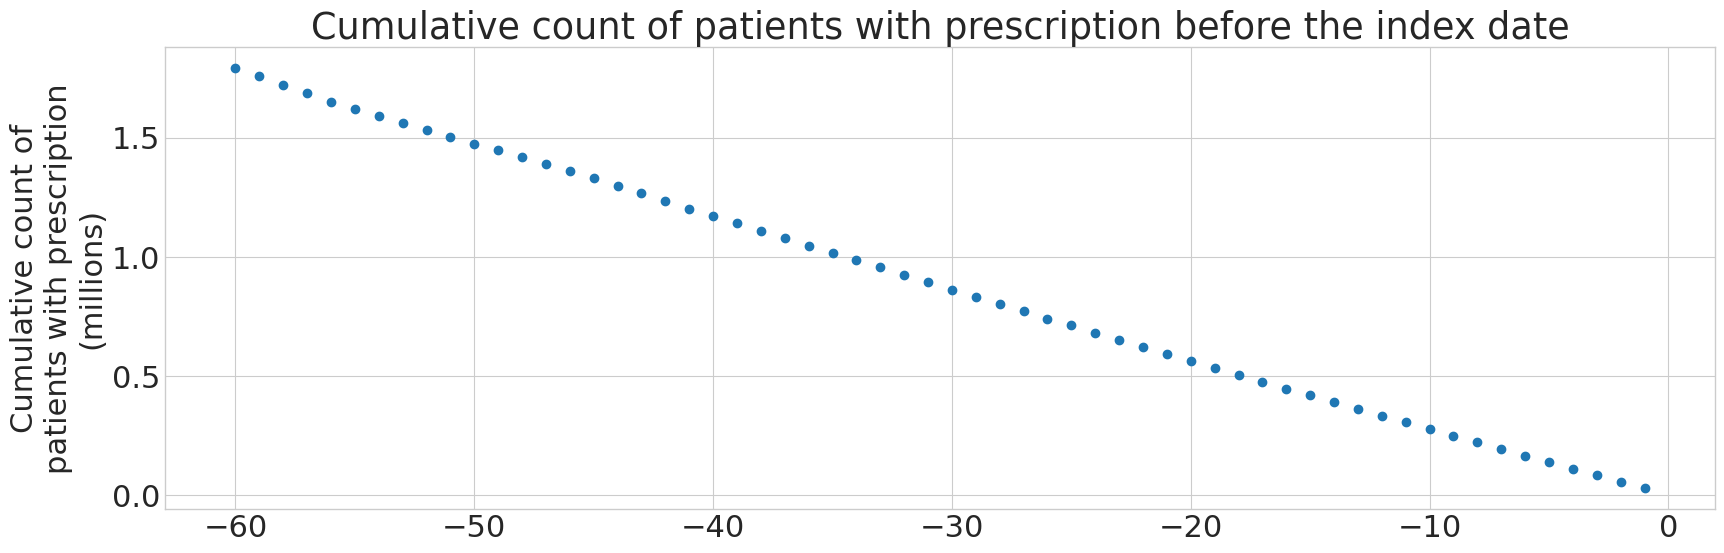

In [8]:
# Calculate cumulative sum.
dataToPlot = list(numpy.cumsum(pt_count_rounded))
dataToPlot.reverse()
dataToPlot = [x / 1000000 for x in dataToPlot]
# Plot.
fig = matplotlib.pyplot.figure(figsize=(20,6))
matplotlib.pyplot.scatter(list(range(-len(dataToPlot),0)), dataToPlot)
matplotlib.pyplot.title('Cumulative count of patients with prescription before the index date')
matplotlib.pyplot.ylabel('Cumulative count of\npatients with prescription\n(millions)')
matplotlib.pyplot.yticks( numpy.arange(0, 2, 0.5) )
matplotlib.pyplot.show()

## Conclusion

The plot of cumulative counts suggest that there is no particular threshold date where prescription patterns change. Therefore, we will follow the clinical team's suggestion of 10 years.